# Задача мультиклассификации
### От бинарной классификации к мультиклассификации 

К этому моменту Вы, так или иначе, научились решать задачу классификации для случая, когда имеется два класса: отрицательный/положительный, черный/белый и т.п. 

Но что делать, когда классов может быть несколько? Как применить наши знания о методах классификации? Как проверить качество полученных результатов классификации? Эти вопросы приводят нас к понятию **Мультиклассификации**. Оговоримся, что зачастую используется термин **Многоклассовая классификация**.

Итак, **мультиклассификация** это задача предсказания класса для объекта в случае, когда классов больше двух.

Вообще говоря, принято считать, что в задаче мультиклассфикации один объект принадлежит только одному классу, что не всегда верно. Подобные задачи называются задачами **множественной классификации**. Техника их решения имеет много общего с решениями задач мультиклассификации. 

### Постановка задачи

Пусть, как и ранее, $X$ - множество описаний объектов (признаки), $y$ - истинная метка класса для каждого объекта (обычно метка обозначается целыми числами:..0,1,2,3...)

Наша цель - найти зависимость между $X$ и $y$

### Пример

Обратимся к классическому примеру классификации - классификации цветков Ириса. 

Требуется классифицировать цветки Ириса по трём (ср. с бинарной классификацией) видам:

* iris setosa
* iris versicolor
* iris virginica

В качестве признаков рассмотрим два параметра: длину и ширину лепестка (ср. с бинарной классификацией)

In [1]:
from classification_helper_mult import * # Подгружаем функции
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,f1_score
import numpy as np

In [2]:
X, kind_iris = get_data(["iris setosa","iris versicolor","iris virginica"])

$X$ - двумерный массив признаков

$kind\_iris$ - вектор истинных видов цветков (*target*)

Отобразим данные в виде таблички и на графике.

Таблица:

In [3]:
print_data(X,kind_iris,columns = ["Длина лепестка", "Ширина лепестка"])

,Длина лепестка,Ширина лепестка,Вид Ириса
0,1.4,0.2,iris setosa
1,1.4,0.2,iris setosa
2,1.3,0.2,iris setosa
3,1.5,0.2,iris setosa
4,1.4,0.2,iris setosa
...,...,...,...
145,5.2,2.3,iris virginica
146,5.0,1.9,iris virginica
147,5.2,2.0,iris virginica
148,5.4,2.3,iris virginica


График:

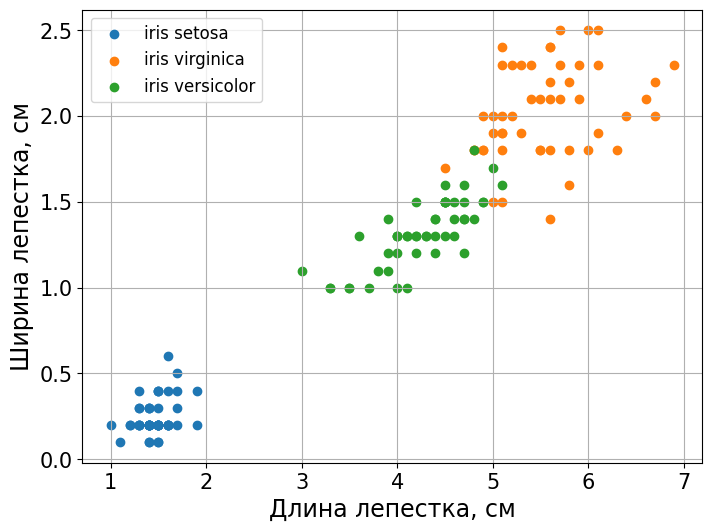

In [4]:
plot_data(X,kind_iris,columns = ["Длина лепестка", "Ширина лепестка"])

Обратим внимание, что Iris Setosa хорошо отделяется от двух других типов ирисов с помощью прямой. Iris Virginica тоже неплохо может отделен от дву других.

Это замечание приводит нас к двум распространенным методам мультиклассификации:

* One vs Rest (Один против остальных)
* One vs One (Один против одного)

### Решение задачи мультиклассификации.

#### One vs Rest (Один против остальных)

Смысл его весьма прост: строятся $K$ базовых бинарных классификаторов, каждый из которых отделяет назначенный ему класс от всех остальных. Побеждает тот класс, которому был присвоен наибольший скор-балл (вероятность) среди всех классификаторов.

Реализуем метод **One vs Rest**. В качестве базового бинарного классификатора возьмем логистическую регрессию из sklearn

In [5]:
class multiclassification_One_vs_rest:
    def __init__(self,classmodel = LogisticRegression):
        self.classmodel = classmodel
        self.models = {}        
        
    def fit(self,X,y):
        dict_iris = {0:"iris setosa",1:"iris versicolor",2:"iris virginica"}        
        labels = set(y)
        models = []
        for label in labels:
            print(f"Обучение модели, отделяющей {dict_iris[label]} от остальных")
            model = self.classmodel(C = 100,solver = "lbfgs")
            y_label = y == label
            model.fit(X,y_label)
            self.models[label] = model
            print("Готово!")
    
    def predict(self,X):        
        labels = np.sort(list(self.models.keys()))
        predictions = np.zeros((len(X),3))
        for label in labels:
            model = self.models[label]
            predictions[:,label] = model.predict_proba(X)[:,1]
        return np.argmax(predictions,axis=1)

И применим метод к задаче классификации ирисов:

In [6]:
dict_iris = {"iris setosa":0,"iris versicolor":1,"iris virginica":2}
Y = np.array([dict_iris[iris] for iris in kind_iris])
columns = ["Длина лепестка", "Ширина лепестка"]
dict_param = {"Длина чашелистника":0, "Ширина чашелистника":1,"Длина лепестка":2,"Ширина лепестка":3}
N = [dict_param[par] for par in columns]
model_One_vs_rest = multiclassification_One_vs_rest()
model_One_vs_rest.fit(X[:,[N[0],N[1]]],Y)

Обучение модели, отделяющей iris setosa от остальных
Готово!
Обучение модели, отделяющей iris versicolor от остальных
Готово!
Обучение модели, отделяющей iris virginica от остальных
Готово!


Отобразим результаты обучения:

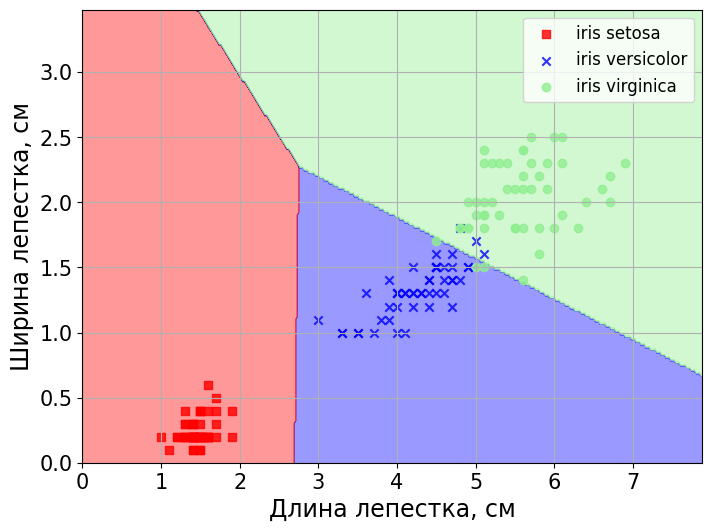

In [7]:
plot_decision_regions(X, Y, classifier=model_One_vs_rest,columns = columns)

Недостатком метода **One vs Rest** можно назвать тот факт, что результат каждого классификатора учитывается одинаково.

#### One vs One (Один против одного)

Еще один популярный метод мультиклассификации - это метод **One vs One** (Один против одного).
Суть его в слеудующем: выделяются все пары классов, и на каждой паре обучается свой собственный бинарный классификатор.
Итоговый класс определяется большинством голосов.

#### Классификация ирисов

Реализуем простой метод **One vs One** с использованием логистической регрессии

In [8]:
class multiclassification_One_vs_one:
    def __init__(self,classmodel = LogisticRegression):
        self.classmodel = classmodel
        self.models = {}        
        
    def fit(self,X,y):
        dict_iris = {0:"iris setosa",1:"iris versicolor",2:"iris virginica"}        
        labels = set(y)
        labels_dual = []
        for label_1 in labels:
            for label_2 in labels:
                if label_1 != label_2:
                    labels_dual.append(tuple(np.sort([label_1,label_2])))
        
        labels_dual = set(labels_dual)        
        models = []
        for label_d in labels_dual:
            print(f"Обучение модели, отделяющей {dict_iris[label_d[0]]} от {dict_iris[label_d[1]]}")
            model = self.classmodel(C = 10, solver = "lbfgs")
            X_ = X[(y == label_d[0]) | (y == label_d[1])]
            y_ = y[(y == label_d[0]) | (y == label_d[1])]
            y_label = y_ == label_d[1]
            model.fit(X_,y_label)
            self.models[label_d] = model
            print("Готово!")
    
    def predict(self,X):        
        labels = self.models.keys()
        predictions = np.zeros((len(X),3))        
        for label in labels:
            model = self.models[label]
            predictions[:,label[0]] = predictions[:,label[0]] + np.invert(model.predict(X))
            predictions[:,label[1]] = predictions[:,label[1]] + model.predict(X)
        return np.argmax(predictions,axis=1)

И применим метод к задаче классификации ирисов:

In [9]:
dict_iris = {"iris setosa":0,"iris versicolor":1,"iris virginica":2}
Y = np.array([dict_iris[iris] for iris in kind_iris])
columns = ["Длина лепестка", "Ширина лепестка"]
dict_param = {"Длина чашелистника":0, "Ширина чашелистника":1,"Длина лепестка":2,"Ширина лепестка":3}
N = [dict_param[par] for par in columns]
model_One_vs_one = multiclassification_One_vs_one()
model_One_vs_one.fit(X[:,[N[0],N[1]]],Y)

Обучение модели, отделяющей iris setosa от iris versicolor
Готово!
Обучение модели, отделяющей iris setosa от iris virginica
Готово!
Обучение модели, отделяющей iris versicolor от iris virginica
Готово!


Отобразим результаты обучения:

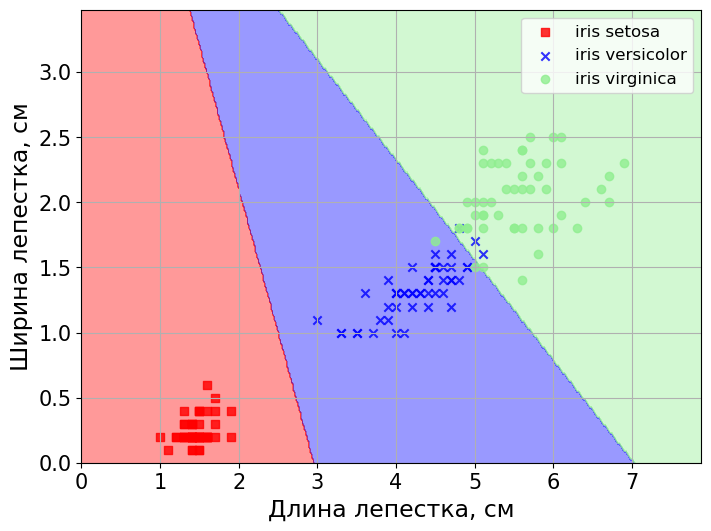

In [10]:
plot_decision_regions(X, Y, classifier=model_One_vs_one, columns = columns)

Недостаткоми метода **One vs One**можно назвать:
* использование большого количества классификаторов ($K(K-1)/2$)
* Возможность коллизий (то есть когда за два класса проголосовало одикавое число классификаторов)

### Softmax.

Модель бинарной классификации часто строится так, чтобы возвращать вероятность принадлежности классу $1$. 

В рассмотренных моделях мультиклассификации вероятность принадлежности к классам в явном виде не фигурирует. Однако фигурирует вектор чисел, каждое $k$-тое из которых характеризует степень уверенности принадлежности к $k$-тому классу.

Этот вектор можно преобразовать так, чтобы сумма всех чисел равнялась единице, и каждое число было бы неотрицательным.
Озвученным требованиям к преобразованию соответствует функция, называемая *softmax*, выглядящая следующим образом:
\begin{equation*}
softmax(x)_k = \dfrac{e^{x_k}}{\sum_{j=1}^{N}e^{x_j}}
\end{equation*}

Набор чисел $softmax(x)_k$ уже можно интерпретировать как вероятность принадлежности классу $k$.

### Softmax как расширение логистической регрессии до задачи мультиклассификации.

*softmax* можно использовать как сигмоиду в логистической регрессии. Для обучения логистической регрессии нам необходимо было минимизировать кросс-энтропию. В случае мультиклассификации можно сделать точно так же: нам необходимо ввести кросс-энтропию. Для вывода мультиклассовой кросс-энтропии вспомним вид бинарной кросс-энтропии для логистической регрессии:

\begin{equation*}
BinaryCrossentropy(W,X,Y) = -\dfrac{1}{N}\sum_{i=1}^{N} y_iln(\sigma(z_i)) + (1-y_i)ln(1-\sigma(z_i))
\end{equation*}

Здесь $z_i=w^Tx_i$, $y_i$ - бинарные метки классов (0 и 1);
Если положить, что $Y_i = (1,0)^T$, если $y_i = 0$, и $Y_i = (0,1)^T$, если $y_i = 1$, а также $SIGMA(z_i) = (\sigma(z_i),1-\sigma(z_i))^T$, то бинарную кросс-энтропию можно записать как:
\begin{equation*}
BinaryCrossentropy(W,X,Y) = -\dfrac{1}{N}\sum_{i=1}^{N}Y_i^Tln(SIGMA(z_i))
\end{equation*}


В случае мультиклассификации обозначим $Y_i = (0,0,...,1,...,0)^T$, где 1 стоит на $k$-том месте, если $i$-тый объект принадлежит к классу $k$ (такая замена метки класса на вектор нулей и единицы называется *one hot encoding*). Вектор $SIGMA(z_i)$ заменим на вектор $softmax(z_i)$, где $z_i = W^TX_i$, $W$ - матрица весов, размерности M * K (M - количество признаков или размерность вектора $X_i$). Обратите внимание, что в случае мультиклассовой классификации $W$ - это именно матрица, а не вектор.

Так, теперь можем записать:
\begin{equation*}
L(W) = crossentropy(W,X,Y) = -\dfrac{1}{N}\sum_{i=1}^{N}Y_i^Tln(softmax(z_i))
\end{equation*}

Здесь $ln(softmax(z_i))$ - это вектор логарифмов каждого компонента вектора $softmax(z_i)$.


Для обучения модели (использования градиентого спуска) необходимо знать производные по всем параметрам $W$ от кросс-энтропии. Эта задача вполне решается:

\begin{equation*}
\dfrac{\partial L(W)}{\partial w_{kj}} = -\dfrac{1}{N}\sum_{i=1}^{N}Y_i^T \dfrac{\partial ln(softmax(z_i(W)))}{\partial w_{kj}}
\end{equation*}

$s$-тый компонент вектора $ln(softmax(z_i(W)))$ может быть выражен как:

\begin{equation*}
ln(softmax(z_i(W))_s) = W_sx_i - ln(\sum_{k=1}^{K}e^{W_kx_i})
\end{equation*}
$W_s$ - $s$-тая строка матрицы $W$.

Тогда производная каждого $s$-того компонента вектора $W_sx_i - ln(\sum_{k=1}^{K}e^{W_kx_i})$ по $w_{kj}$ может быть выражена как:
\begin{equation*}
\dfrac{\partial (W_sx_i - ln(\sum_{k=1}^{K}e^{W_kx_i}))}{\partial w_{kj}} = \begin{cases}
x_{i,j} - \dfrac{x_{i,j}e^{W_kx_i}}{\sum_{k=1}^{K}e^{W_kx_i}}, s = k, \\
- \dfrac{x_{i,j}e^{W_kx_i}}{\sum_{k=1}^{K}e^{W_kx_i}}, s \neq k
\end{cases}
= \begin{cases}
x_{i,j} - x_{i,j}softmax(Wx_i)_k, s = k, \\
- x_{i,j}softmax(Wx_i)_k, s \neq k
\end{cases}
\end{equation*}

Введем единичный вектор $e_k$ - вектор из нулей, кроме $k$-того элемента, который равен единице. Тогда производная вектора $Wx_i - ln(\sum_{k=1}^{K}e^{W_kx_i})$ по $w_{kj}$  может быть выражена как:
\begin{equation*}
\dfrac{\partial Wx_i - ln(\sum_{k=1}^{K}e^{W_kx_i})}{\partial w_{kj}} = x_{ij}(e_k - softmax(Wx_i)_k)
\end{equation*}


Тогда производная функции $L(W)$ может быть записана:
\begin{equation*}
\dfrac{\partial L(W)}{\partial w_{kj}} = -\dfrac{1}{N}\sum_{i=1}^{N}Y_i^Tx_{ij}(e_k - softmax(Wx_i)_k)
\end{equation*}


Раз получена формула для производной по каждому весу, то можно немедленно воспользоваться уже знакомым градиентным спуском для обучения многоклассовой логистической регрессии.


In [4]:
# Вспомогательные функции

# реализуем softmax:
def Loss(X,W,Y):      
    return -np.mean(np.sum(Y * np.log(softmax(X,W).T),axis = 1))

# реализуем softmax:
def softmax(X,W):
    return np.exp(W @ X.T) / np.sum(np.exp(W @ X.T),axis = 0)

# реализуем one hot encoding:
def one_hot_encoding(Y):
    Y_ = np.zeros((len(Y),3))
    Y_[Y == 0,0] = 1
    Y_[Y == 1,1] = 1
    Y_[Y == 2,2] = 1
    return Y_

# реализуем вычисление градиента:
def gradient_function(W, X, Y):
    grad = np.zeros_like(W)
    soft = softmax(X,W)
    for k in range(W.shape[0]):
        ek = np.zeros((W.shape[0],1))
        ek[k] = 1
        ek_softmax = ek - soft[k,:]
        for j in range(W.shape[1]):
            sum_ = np.sum(Y * ek_softmax.T,axis = 1)
            grad[k,j] = -np.mean(X[:, j] * sum_)
    return grad

# Добавление единичного столбца
def create_data(X):
    X_ones = np.ones(X.shape[0])
    return np.column_stack([X_ones, X])

# Градиентный спуск
def gradient_descent(W, X, y, alpha, iters):        
    w = W
    for i in range(iters):
        w = w - alpha * gradient_function(w, X, y)
        if i % 400 == 0:
            print("Loss функция:",Loss(X,w,y))        
    return w

Реализуем метод softmax:

In [11]:
class multiclassification_softmax:
    def __init__(self):
        self.W = None
        
    def fit(self,X,y):
        W = np.random.randn(3,3)*0.1
        self.W = gradient_descent(W, X, y, alpha=0.1, iters=4000)
        print("Готово!")
    
    def predict(self,X):        
        predictions = softmax(X,self.W)
        return np.argmax(predictions,axis=0)

И применим метод к задаче классификации ирисов:

In [12]:
dict_iris = {"iris setosa":0,"iris versicolor":1,"iris virginica":2}
Y = np.array([dict_iris[iris] for iris in kind_iris])
Y_ = one_hot_encoding(Y)
columns = ["Длина лепестка", "Ширина лепестка"]
dict_param = {"Длина чашелистника":0, "Ширина чашелистника":1,"Длина лепестка":2,"Ширина лепестка":3}
N = [dict_param[par] for par in columns]
model_softmax = multiclassification_softmax()
X_ = create_data(X)
X_train = X_[:,[0,N[0]+1,N[1]+1]]
model_softmax.fit(X_train,Y_)

Loss функция: 0.9929328209973174
Loss функция: 0.4159215123520111
Loss функция: 0.3277528295476958
Loss функция: 0.2825282422883876
Loss функция: 0.2530016636048037
Loss функция: 0.2316208521333879
Loss функция: 0.2152071166432167
Loss функция: 0.2021142985090867
Loss функция: 0.1913783419504754
Loss функция: 0.18238725530863906
Готово!


Отобразим результаты обучения:

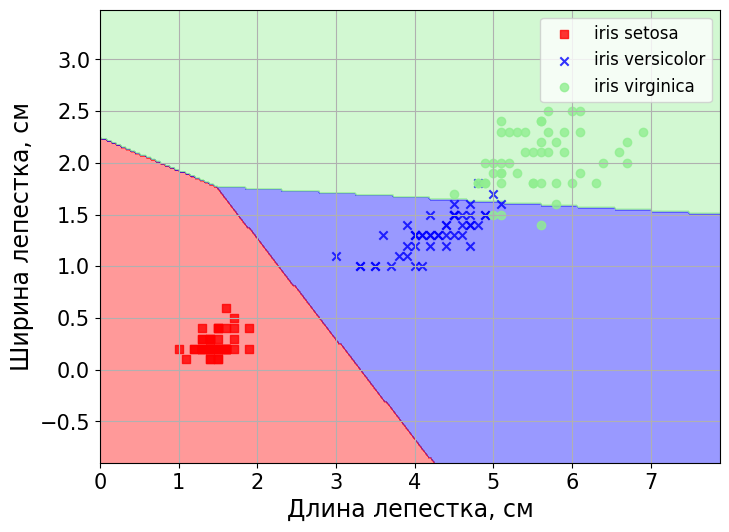

In [13]:
plot_decision_regions_softmax(X, Y, classifier=model_softmax , columns = columns)

Модель softmax по своему построению сглаживает недостаток One vs Rest.

Стоит отметить, softmax играет важнейшую роль в более сложных моделях мультиклассификации (например, в нейронных сетях)

### Метрики качества в задаче мультиклассификации

Метрики качества задачи мультиклассификации мало чем отличаются от бинарной классификации. 
Метрика *accuracy* считает долю верных ответов.

Для наших моделей:

In [18]:
y_pred_One_vs_all = model_One_vs_rest.predict(X[:,[N[0],N[1]]])
y_pred_One_vs_one = model_One_vs_one.predict(X[:,[N[0],N[1]]])
y_pred_softmax = model_softmax.predict(X_train)

In [19]:
print("Метрика Accuracy для модели One vs All на тренировочных данных:",np.mean(Y == y_pred_One_vs_all))
print("Метрика Accuracy для модели One vs One на тренировочных данных:",np.mean(Y == y_pred_One_vs_one))
print("Метрика Accuracy для модели softmax на тренировочных данных:",np.mean(Y == y_pred_softmax))

Метрика Accuracy для модели One vs All на тренировочных данных: 0.96
Метрика Accuracy для модели One vs One на тренировочных данных: 0.9666666666666667
Метрика Accuracy для модели softmax на тренировочных данных: 0.9666666666666667


precision, recall и f1-score также считаюся в мультиклассификации. Можно рассмотреть следующие варианты:
1. macro-метрики;
2. weighted-метрики.

macro-метрики рассчитываются по каждому классу отдельно и усредняются

In [121]:
def precision_score_macro(y_pred,y_true):
    P = 0
    for y in set(y_true):
        P = P + precision_score(y_true=y_true==y,y_pred=y_pred==y)
    return P/len(set(y_true))

def recall_score_macro(y_pred,y_true):
    P = 0
    for y in set(y_true):
        P = P + recall_score(y_true=y_true==y,y_pred=y_pred==y)
    return P/len(set(y_true))


def f1_score_macro(y_pred,y_true):
    P = 0
    for y in set(y_true):
        P = P + f1_score(y_true=y_true==y,y_pred=y_pred==y)
    return P/len(set(y_true))

In [122]:
print("Метрика precision-macro для модели One vs All на тренировочных данных:",precision_score_macro(y_pred_One_vs_all,Y))
print("Метрика precision-macro для модели One vs One на тренировочных данных:",precision_score_macro(y_pred_One_vs_one,Y))
print("Метрика precision-macro для модели softmax на тренировочных данных:",precision_score_macro(y_pred_softmax,Y))
print()
print("Метрика recall-macro для модели One vs All на тренировочных данных:",recall_score_macro(y_pred_One_vs_all,Y))
print("Метрика recall-macro для модели One vs One на тренировочных данных:",recall_score_macro(y_pred_One_vs_one,Y))
print("Метрика recall-macro для модели softmax на тренировочных данных:",recall_score_macro(y_pred_softmax,Y))
print()
print("Метрика f1_score-macro для модели One vs All на тренировочных данных:",f1_score_macro(y_pred_One_vs_all,Y))
print("Метрика f1_score-macro для модели One vs One на тренировочных данных:",f1_score_macro(y_pred_One_vs_one,Y))
print("Метрика f1_score-macro для модели softmax на тренировочных данных:",f1_score_macro(y_pred_softmax,Y))


Метрика precision-macro для модели One vs All на тренировочных данных: 0.96
Метрика precision-macro для модели One vs One на тренировочных данных: 0.9667867146858743
Метрика precision-macro для модели softmax на тренировочных данных: 0.9667867146858743

Метрика recall-macro для модели One vs All на тренировочных данных: 0.96
Метрика recall-macro для модели One vs One на тренировочных данных: 0.9666666666666667
Метрика recall-macro для модели softmax на тренировочных данных: 0.9666666666666667

Метрика f1_score-macro для модели One vs All на тренировочных данных: 0.96
Метрика f1_score-macro для модели One vs One на тренировочных данных: 0.9666633329999667
Метрика f1_score-macro для модели softmax на тренировочных данных: 0.9666633329999667


weighted-метрики рассчитываются по каждому классу отдельно и усредняются с весами. Весами явлеятся доля класса в выборке

In [56]:
def precision_score_weighted(y_pred,y_true):
    P = 0
    for y in set(y_true):
        P = P + (y_true == y).sum()/len(y_true) * precision_score(y_true=y_true==y,y_pred=y_pred==y)
    return P

def recall_score_weighted(y_pred,y_true):
    P = 0
    for y in set(y_true):
        P = P + (y_true == y).sum()/len(y_true) * recall_score(y_true=y_true==y,y_pred=y_pred==y)
    return P


def f1_score_weighted(y_pred,y_true):
    P = 0
    for y in set(y_true):
        P = P + (y_true == y).sum()/len(y_true) * f1_score(y_true=y_true==y,y_pred=y_pred==y)
    return P

In [123]:
print("Метрика precision-weighted для модели One vs All на тренировочных данных:",precision_score_micro(y_pred_One_vs_all,Y))
print("Метрика precision-weighted для модели One vs One на тренировочных данных:",precision_score_micro(y_pred_One_vs_one,Y))
print("Метрика precision-weighted для модели softmax на тренировочных данных:",precision_score_micro(y_pred_softmax,Y))
print()
print("Метрика recall-weighted для модели One vs All на тренировочных данных:",recall_score_micro(y_pred_One_vs_all,Y))
print("Метрика recall-weighted для модели One vs One на тренировочных данных:",recall_score_micro(y_pred_One_vs_one,Y))
print("Метрика recall-weighted для модели softmax на тренировочных данных:",recall_score_micro(y_pred_softmax,Y))
print()
print("Метрика f1_score-weighted для модели One vs All на тренировочных данных:",f1_score_micro(y_pred_One_vs_all,Y))
print("Метрика f1_score-weighted для модели One vs One на тренировочных данных:",f1_score_micro(y_pred_One_vs_one,Y))
print("Метрика f1_score-weighted для модели softmax на тренировочных данных:",f1_score_micro(y_pred_softmax,Y))

Метрика precision-weighted для модели One vs All на тренировочных данных: 0.96
Метрика precision-weighted для модели One vs One на тренировочных данных: 0.9666666666666667
Метрика precision-weighted для модели softmax на тренировочных данных: 0.9666666666666667

Метрика recall-weighted для модели One vs All на тренировочных данных: 0.96
Метрика recall-weighted для модели One vs One на тренировочных данных: 0.9666666666666667
Метрика recall-weighted для модели softmax на тренировочных данных: 0.9666666666666667

Метрика f1_score-weighted для модели One vs All на тренировочных данных: 0.96
Метрика f1_score-weighted для модели One vs One на тренировочных данных: 0.9666666666666667
Метрика f1_score-weighted для модели softmax на тренировочных данных: 0.9666666666666667


Отметим, что macro-метрики являются более чувствительными к ошибкам на малых классах.

Приведем пример.

Пусть истинные метки классов выглядят следующим образом:

In [130]:
y_true = np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2])

То есть класс 2 представлен незначительно.

Пусть предсказание выглядит так:

In [131]:
y_pred = np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0])

То есть модель полностью исключила класс 2.

В результате так выглядят метрики:

In [132]:
print("Метрика precision-weighted:",precision_score_weighted(y_pred,y_true))
print("Метрика precision-macro:",precision_score_macro(y_pred,y_true))
print()
print("Метрика recall-weighted:",recall_score_weighted(y_pred,y_true))
print("Метрика recall-macro:",recall_score_macro(y_pred,y_true))
print()
print("Метрика f1_score-weighted:",f1_score_weighted(y_pred,y_true))
print("Метрика f1_score-macro:",f1_score_macro(y_pred,y_true))

Метрика precision-weighted: 0.7673611111111112
Метрика precision-macro: 0.5833333333333334

Метрика recall-weighted: 0.875
Метрика recall-macro: 0.6666666666666666

Метрика f1_score-weighted: 0.8171936758893281
Метрика f1_score-macro: 0.6218708827404479


Как видно, в случае macro-метрик все значения ниже соответствующих weighted-метрик